In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC
import sklearn.preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/61/29/fc60b2de1713aa92946992544329f20ccb5e4ba26290f403e04b7da44105/opencv_contrib_python-3.4.2.17-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: tensor2tensor 1.14.1 requires opencv-python, which is not installed.
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug

In [2]:
# Downloading dataset
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-03-27 06:45:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  50.1MB/s    in 3.6s    

2020-03-27 06:45:21 (45.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!tar -xf cifar-10-python.tar.gz

In [0]:
# Defining method to unload images

def unpickle_batch(file):
    import pickle
    with open(file, 'rb') as fo:
        bdict = pickle.load(fo, encoding='latin-1')
        nImgs = len(bdict['data'])
        imgs = bdict['data'].reshape(nImgs,3,32,32).transpose(0, 2, 3, 1)
        labels = bdict['labels']
    return (imgs,labels)

In [0]:
# loading all batches : data_batches_1-4 and test_batch used for training and data_batch_5 used for testing 
# as test_batch was used for validation

images = []
labels = []
no_of_batches = 4
path = 'cifar-10-batches-py/data_batch_'
batch_id = 1
for batch_id in range(batch_id,no_of_batches+1):
    batch_images,batch_labels = unpickle_batch(path+str(batch_id))
    for each in batch_images:
        images.append(each)
    for each in batch_labels:
        labels.append(each)

In [0]:
# extending training batch and labels with test_batch and test_labels respectively

images.extend(test_images)
labels.extend(test_labels)

In [11]:
#len(images)
len(labels)

50000

In [10]:
len(images)

50000

In [9]:
images[49000].shape

(32, 32, 3)

In [0]:
def unpickle_metadata(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin-1')
    return dict

In [0]:
label_names_dict = unpickle_metadata('cifar-10-batches-py/batches.meta')

In [0]:
label_names=label_names_dict['label_names']

In [15]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

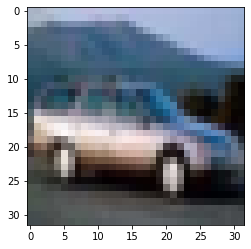

In [16]:
plt.imshow(images[4],cmap = 'gray')

In [17]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
images_per_batch = label_names_dict['num_cases_per_batch']

In [19]:
images_per_batch

10000

In [20]:
label_names_dict

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

In [0]:
def gray(img):
    grayImage = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return grayImage

In [0]:
# defining method to get descriptors using SIFT
sift = cv2.xfeatures2d.SIFT_create()
def getFeatures(img):
    kp,desc = sift.detectAndCompute(img,mask=None)
    return kp,desc

In [0]:
# Creating descriptors for each image

kp_list = []
desc_list = []
for each in images:
    grayimage = gray(each)
    kp,desc = getFeatures(each)
    if desc is None:
        zero = np.zeros([1,128],dtype='float32')
        desc_list.append(zero)
        continue
    kp_list.append(kp)
    desc_list.append(desc)

In [26]:
len(kp_list)
len(desc_list)
#desc_list[996].shape

50000

In [27]:
des_ary = np.array(desc_list)
des_ary.shape

(50000,)

In [0]:
# Restructuring descriptor list

def restructure(des_list):
    featlist = np.array(des_list[0])
    for remaining in des_list[1:]:
        featlist = np.vstack((featlist,remaining))
    return featlist

In [0]:
X = restructure(desc_list)

In [30]:
X.shape

(651089, 128)

In [0]:
# Using KMeans to cluster features :16 , 128, 256

nclusters = 64
kmeans = KMeans(nclusters)
kret_labels = kmeans.fit_predict(X)

In [35]:
kret_labels

array([24, 21,  4, ..., 51, 47,  7], dtype=int32)

In [36]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=64, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# Function to generate VLADs
def genVLAD(descriptors,vocab):
    descDim = 128 # 128 = dimension of descriptor
    VLADs = []
    
    for i in range(descriptors.shape[0]):
        VLAD = np.zeros((nclusters,descDim))
        pred = vocab.predict(descriptors[i])
        dist = descriptors[i] - vocab.cluster_centers_[pred]
        for j in range(descriptors[i].shape[0]):
            VLAD[pred[j]] += dist[j]
#         print(VLAD.shape)
#         VLAD = np.reshape(VLAD,(-1,1))
#         print(VLAD.shape)
        VLAD_normalized = prep.normalize(VLAD,norm = 'l2')
        
        VLADs.append(VLAD_normalized)
    return VLADs
    

In [0]:
# Getting VLADs 

VLADs = genVLAD(des_ary,kmeans)

In [0]:
# flattening 

data = []
for i in range(len(VLADs)):
    flatImgVec = [ele for li_1d in VLADs[i] for ele in li_1d]
    data.append(flatImgVec)

In [44]:
len(data)

50000

In [45]:
len(flatImgVec)

8192

In [0]:
del X

In [0]:
# Scaling

dataset = np.asarray(data)
scale = StandardScaler().fit(dataset)
dataset = scale.transform(dataset)

In [59]:
dataset.shape

(50000, 8192)

In [0]:
# Performing PCA components reduction

pca = PCA(n_components=128)
dataset = pca.fit_transform(dataset)

In [61]:
dataset[0].shape

(128,)

In [0]:
# Performing hyperparameter search ov SVM

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10), "kernel":['rbf'] } 
rnd_search_cv = RandomizedSearchCV(SVC(), param_distributions, n_iter=10, verbose=2, cv=5, random_state=42)
rnd_search_cv.fit(dataset, labels)

rnd_search_cv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf, total= 5.0min
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min remaining:    0.0s


[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf, total= 5.1min
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf ......
[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf, total= 5.1min
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf ......
[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf, total= 5.2min
[CV] C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf ......
[CV]  C=4.745401188473625, gamma=0.07969454818643928, kernel=rbf, total= 5.1min
[CV] C=8.31993941811405, gamma=0.015751320499779724, kernel=rbf ......
[CV]  C=8.31993941811405, gamma=0.015751320499779724, kernel=rbf, total= 5.1min
[CV] C=8.31993941811405, gamma=0.015751320499779724, kernel=rbf ......
[CV]  C=8.31993941811405, gamma=0.015751320499779724, kernel=rbf, total= 5.3min
[CV] C=8.31993941811405, gamma=0.015751320499779724, kernel=rbf ......
[CV]  C=8.31993941811405, gamma=0.015751320499779724, kernel=rbf, total= 5.0min
[CV] C=8.31993

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 253.5min finished


SVC(C=2.560186404424365, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.002051110418843397, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [62]:
# Training SVM

# nClusters = 800
# svm_c = 0.01
# svm_gamma = 0.01
# svm_kernal = 'linear'

#model = svm.SVC()#C=svm_c, gamma = svm_gamma, kernel = 'linear')
# model = svm.SVC(C=2.560186404424365, break_ties=False, cache_size=200, class_weight=None,
#     coef0=0.0, decision_function_shape='ovr', degree=3,
#     gamma=0.002051110418843397, kernel='rbf', max_iter=-1, probability=False,
#     random_state=None, shrinking=True, tol=0.001, verbose=False)

model = svm.SVC(C=2.560186404424365, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.002051110418843397, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
model.fit(dataset,labels)

SVC(C=2.560186404424365, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.002051110418843397, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [63]:
# Simple SVC k = 64 pca = 128 l2 normalized hypertuned on 30k detection on 50000
print(classification_report(model.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      5285
           1       0.98      1.00      0.99      4910
           2       0.96      0.94      0.95      5140
           3       0.97      0.99      0.98      4883
           4       0.96      0.98      0.97      4880
           5       0.98      1.00      0.99      4894
           6       0.97      0.99      0.98      4964
           7       0.98      1.00      0.99      4932
           8       0.96      0.93      0.94      5211
           9       0.98      1.00      0.99      4901

    accuracy                           0.97     50000
   macro avg       0.97      0.97      0.97     50000
weighted avg       0.97      0.97      0.97     50000



In [0]:
# Simple SVC k = 64 pca = 128 l2 normalized hypertuned on 30000
print(classification_report(model.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3155
           1       0.98      1.00      0.99      2986
           2       0.96      0.94      0.95      3070
           3       0.98      0.99      0.98      2952
           4       0.97      0.99      0.98      2946
           5       0.98      1.00      0.99      2906
           6       0.98      0.99      0.99      2965
           7       0.99      1.00      0.99      3000
           8       0.97      0.94      0.96      3062
           9       0.99      1.00      0.99      2958

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



In [0]:
# Simple SVC k = 256 pca = 128 l2 normalized hypertuned
print(classification_report(model.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1063
           1       0.99      1.00      0.99       964
           2       0.97      0.94      0.95      1065
           3       0.98      1.00      0.99       993
           4       0.96      0.99      0.98       975
           5       0.99      1.00      0.99       925
           6       0.98      1.00      0.99      1007
           7       0.99      1.00      1.00       993
           8       0.98      0.96      0.97      1044
           9       0.99      1.00      0.99       971

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [0]:
# Simple SVC k = 256 pca = 128 l2 normalized
print(classification_report(model.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1000
           1       0.69      0.76      0.72       883
           2       0.62      0.44      0.52      1439
           3       0.59      0.70      0.64       860
           4       0.61      0.56      0.58      1086
           5       0.62      0.80      0.70       723
           6       0.63      0.69      0.66       937
           7       0.69      0.83      0.75       827
           8       0.65      0.50      0.57      1327
           9       0.71      0.76      0.73       918

    accuracy                           0.64     10000
   macro avg       0.64      0.66      0.64     10000
weighted avg       0.64      0.64      0.63     10000



In [0]:
# Simple SVC k = 256 pca = 128
print(classification_report(model.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55      1066
           1       0.67      0.74      0.70       887
           2       0.57      0.41      0.48      1457
           3       0.59      0.67      0.63       895
           4       0.57      0.58      0.57       976
           5       0.61      0.78      0.68       728
           6       0.59      0.65      0.62       933
           7       0.65      0.80      0.72       810
           8       0.63      0.50      0.56      1304
           9       0.70      0.72      0.71       944

    accuracy                           0.61     10000
   macro avg       0.61      0.64      0.62     10000
weighted avg       0.61      0.61      0.61     10000



In [0]:
# Simple SVC k = 128 PCA =64
print(classification_report(model.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1030
           1       0.66      0.71      0.68       907
           2       0.55      0.41      0.47      1388
           3       0.56      0.65      0.60       875
           4       0.57      0.51      0.54      1104
           5       0.56      0.76      0.65       693
           6       0.59      0.64      0.61       956
           7       0.62      0.74      0.68       844
           8       0.62      0.51      0.56      1250
           9       0.66      0.68      0.67       953

    accuracy                           0.60     10000
   macro avg       0.60      0.62      0.60     10000
weighted avg       0.60      0.60      0.59     10000



In [64]:
# Training OnevsRest Classifier

from sklearn.multiclass import OneVsRestClassifier
#m = OneVsRestClassifier(SVC())
# m = OneVsRestClassifier(SVC(C=2.560186404424365, break_ties=False, cache_size=200, class_weight=None,
#     coef0=0.0, decision_function_shape='ovr', degree=3,
#     gamma=0.002051110418843397, kernel='rbf', max_iter=-1, probability=False,
#     random_state=None, shrinking=True, tol=0.001, verbose=False))
m = OneVsRestClassifier(SVC(C=2.560186404424365, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.002051110418843397, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False))
m.fit(dataset,labels)

OneVsRestClassifier(estimator=SVC(C=2.560186404424365, break_ties=False,
                                  cache_size=200, class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.002051110418843397, kernel='rbf',
                                  max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [65]:
# onevsall  k= 64 PCA = 128 l2 normalized HYPERTUNED on 30000 trained on 50k
print(classification_report(m.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5024
           1       1.00      1.00      1.00      4965
           2       0.97      0.96      0.97      5090
           3       0.99      1.00      0.99      4939
           4       0.98      0.99      0.99      4932
           5       1.00      1.00      1.00      4960
           6       0.99      0.99      0.99      4996
           7       1.00      1.00      1.00      5017
           8       0.98      0.96      0.97      5114
           9       1.00      1.00      1.00      4963

    accuracy                           0.99     50000
   macro avg       0.99      0.99      0.99     50000
weighted avg       0.99      0.99      0.99     50000



In [0]:
# onevsall  k= 64 PCA = 128 l2 normalized HYPERTUNED on 30000
print(classification_report(m.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3079
           1       1.00      1.00      1.00      3015
           2       0.97      0.98      0.98      2971
           3       0.99      1.00      0.99      2984
           4       0.98      0.99      0.99      2973
           5       1.00      1.00      1.00      2945
           6       0.99      1.00      0.99      2992
           7       1.00      1.00      1.00      3039
           8       0.98      0.97      0.97      3015
           9       1.00      1.00      1.00      2987

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [0]:
# onevsall  k= 256 PCA = 128 l2 normalized HYPERTUNED
print(classification_report(m.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1035
           1       1.00      1.00      1.00       972
           2       0.98      0.99      0.98      1023
           3       1.00      1.00      1.00      1013
           4       0.99      0.99      0.99       990
           5       1.00      1.00      1.00       934
           6       0.99      1.00      1.00      1025
           7       1.00      1.00      1.00       999
           8       0.99      0.99      0.99      1029
           9       1.00      1.00      1.00       980

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [0]:
# onevsall  k= 256 PCA = 128 l2 normalized
print(classification_report(m.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1051
           1       0.95      0.97      0.96       956
           2       0.90      0.89      0.89      1043
           3       0.94      0.97      0.96       986
           4       0.92      0.93      0.93       990
           5       0.95      0.97      0.96       918
           6       0.94      0.97      0.96       997
           7       0.95      0.98      0.97       974
           8       0.93      0.84      0.89      1134
           9       0.94      0.97      0.96       951

    accuracy                           0.93     10000
   macro avg       0.93      0.94      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [0]:
# onevsall  k= 256 PCA = 128
print(classification_report(m.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1057
           1       0.93      0.95      0.94       952
           2       0.87      0.87      0.87      1039
           3       0.92      0.96      0.94       974
           4       0.90      0.90      0.90       997
           5       0.94      0.97      0.96       907
           6       0.92      0.94      0.93      1012
           7       0.93      0.96      0.95       974
           8       0.92      0.83      0.87      1133
           9       0.94      0.96      0.95       955

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.91     10000



In [0]:
# onevsall  k= 128
print(classification_report(m.predict(dataset),labels))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1063
           1       0.92      0.94      0.93       954
           2       0.84      0.82      0.83      1056
           3       0.91      0.95      0.93       973
           4       0.88      0.89      0.88       989
           5       0.91      0.97      0.94       882
           6       0.91      0.91      0.91      1029
           7       0.92      0.94      0.93       982
           8       0.89      0.81      0.85      1126
           9       0.92      0.95      0.93       946

    accuracy                           0.89     10000
   macro avg       0.89      0.90      0.90     10000
weighted avg       0.89      0.89      0.89     10000



## **Validation & Testing**

In [0]:
# Unloading test batch
test_images = []
test_labels = []
no_of_batches = 1
path = 'cifar-10-batches-py/data_batch_5'
test_batch_images, test_batch_labels = unpickle_batch(path)
for each in test_batch_images:
    test_images.append(each)
for each in test_batch_labels:
    test_labels.append(each)

In [0]:
# Converting all to gray
for i in range(len(test_images)):
    test_images[i] = gray(test_images[i])

In [69]:
len(test_images)
len(test_labels)

10000

In [0]:
def classify(img):
    kp,des = getFeatures(img)
    if des is None:
        return [0]
    else :
        deslist=[des]
        #print(len(deslist))
        VLAD = genVLAD(np.array(deslist),kmeans)
        #print(len(VLAD))
        flatVec = [ele for li_1d in VLAD[0] for ele in li_1d]
        VecList = [flatVec]
        #print(len(flat222))
        Vec = np.asarray(VecList)
        #print(Vec.shape)
        word_strength = scale.transform(Vec)
        #print(word_strength.shape)
        word_strength = pca.transform(word_strength)
        prediction = model.predict(word_strength)
        return prediction

In [0]:
# Classfying each Image
count = 1
prediction = []
for each in test_images:
    prediction.append(classify(each))
    #print(count)
    #count= count+1
    
    

In [0]:
# Validation 

In [0]:
# With 128 words and one vs all
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.34      0.43      0.38      1000
           1       0.34      0.31      0.33      1000
           2       0.19      0.16      0.17      1000
           3       0.17      0.14      0.15      1000
           4       0.16      0.15      0.16      1000
           5       0.30      0.21      0.25      1000
           6       0.23      0.34      0.28      1000
           7       0.31      0.27      0.29      1000
           8       0.31      0.39      0.35      1000
           9       0.30      0.26      0.28      1000

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.26     10000
weighted avg       0.27      0.27      0.26     10000



In [0]:
# With 256 words and one vs all pca = 128
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.34      0.45      0.39      1000
           1       0.37      0.34      0.36      1000
           2       0.19      0.19      0.19      1000
           3       0.17      0.13      0.15      1000
           4       0.15      0.15      0.15      1000
           5       0.28      0.20      0.23      1000
           6       0.20      0.28      0.23      1000
           7       0.32      0.26      0.28      1000
           8       0.31      0.38      0.34      1000
           9       0.35      0.29      0.32      1000

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.26     10000
weighted avg       0.27      0.27      0.26     10000



In [0]:
# With 256 words and one vs all pca = 128 with l2 normalization
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.39      0.37      0.38      1000
           2       0.19      0.19      0.19      1000
           3       0.18      0.14      0.15      1000
           4       0.18      0.18      0.18      1000
           5       0.28      0.19      0.23      1000
           6       0.22      0.30      0.25      1000
           7       0.34      0.25      0.29      1000
           8       0.31      0.42      0.36      1000
           9       0.36      0.28      0.31      1000

    accuracy                           0.28     10000
   macro avg       0.28      0.28      0.27     10000
weighted avg       0.28      0.28      0.27     10000



In [0]:
# With 256 words and one vs all pca = 128 with l2 normalization Hypertuned
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.32      0.47      0.38      1000
           1       0.39      0.26      0.31      1000
           2       0.17      0.25      0.21      1000
           3       0.19      0.13      0.15      1000
           4       0.18      0.21      0.20      1000
           5       0.30      0.14      0.19      1000
           6       0.21      0.27      0.24      1000
           7       0.34      0.20      0.25      1000
           8       0.28      0.47      0.35      1000
           9       0.36      0.19      0.25      1000

    accuracy                           0.26     10000
   macro avg       0.27      0.26      0.25     10000
weighted avg       0.27      0.26      0.25     10000



In [0]:
# With 64 words and one vs all pca = 128 with l2 normalization Hypertuned on 30000
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.41      0.45      0.43      1000
           1       0.39      0.43      0.41      1000
           2       0.22      0.20      0.21      1000
           3       0.21      0.16      0.18      1000
           4       0.20      0.19      0.19      1000
           5       0.30      0.28      0.29      1000
           6       0.30      0.36      0.33      1000
           7       0.34      0.35      0.35      1000
           8       0.37      0.43      0.39      1000
           9       0.35      0.33      0.34      1000

    accuracy                           0.32     10000
   macro avg       0.31      0.32      0.31     10000
weighted avg       0.31      0.32      0.31     10000



In [0]:
# With 128 words and svc
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.35      0.40      0.37      1000
           1       0.39      0.23      0.29      1000
           2       0.19      0.33      0.24      1000
           3       0.23      0.15      0.18      1000
           4       0.16      0.26      0.20      1000
           5       0.39      0.16      0.23      1000
           6       0.24      0.29      0.26      1000
           7       0.40      0.21      0.28      1000
           8       0.32      0.45      0.37      1000
           9       0.35      0.25      0.30      1000

    accuracy                           0.27     10000
   macro avg       0.30      0.27      0.27     10000
weighted avg       0.30      0.27      0.27     10000



In [0]:
# With 256 words and svc PCA = 128
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.32      0.41      0.36      1000
           1       0.45      0.22      0.29      1000
           2       0.16      0.36      0.22      1000
           3       0.21      0.10      0.14      1000
           4       0.16      0.25      0.20      1000
           5       0.39      0.12      0.18      1000
           6       0.22      0.25      0.23      1000
           7       0.44      0.14      0.22      1000
           8       0.27      0.45      0.34      1000
           9       0.38      0.23      0.28      1000

    accuracy                           0.25     10000
   macro avg       0.30      0.25      0.25     10000
weighted avg       0.30      0.25      0.25     10000



In [0]:
# With 64 words and svc pca = 128 with l2 normalization Hypertuned on 30000
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43      1000
           1       0.42      0.41      0.41      1000
           2       0.23      0.21      0.22      1000
           3       0.23      0.18      0.20      1000
           4       0.24      0.23      0.24      1000
           5       0.30      0.30      0.30      1000
           6       0.32      0.34      0.33      1000
           7       0.31      0.38      0.34      1000
           8       0.41      0.39      0.40      1000
           9       0.35      0.37      0.36      1000

    accuracy                           0.33     10000
   macro avg       0.32      0.33      0.32     10000
weighted avg       0.32      0.33      0.32     10000



## Testing 

In [72]:
#Final Accuracy on One VS All

# With 64 words and one vs all pca = 128 with l2 normalization Hypertuned on 30k trained on 50k
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.42      0.45      0.43      1014
           1       0.41      0.44      0.42      1014
           2       0.23      0.21      0.22       952
           3       0.23      0.15      0.19      1016
           4       0.24      0.23      0.24       997
           5       0.31      0.28      0.29      1025
           6       0.28      0.33      0.30       980
           7       0.36      0.39      0.38       977
           8       0.39      0.45      0.42      1003
           9       0.35      0.36      0.35      1022

    accuracy                           0.33     10000
   macro avg       0.32      0.33      0.32     10000
weighted avg       0.32      0.33      0.32     10000



In [77]:
# Final Accuracy on Test Set

# With 64 words and svc pca = 128 with l2 normalization Hypertuned on 50000
print(classification_report(test_labels,np.array(prediction)))

              precision    recall  f1-score   support

           0       0.43      0.44      0.44      1014
           1       0.42      0.44      0.43      1014
           2       0.25      0.24      0.25       952
           3       0.24      0.17      0.20      1016
           4       0.24      0.23      0.24       997
           5       0.30      0.31      0.31      1025
           6       0.32      0.33      0.33       980
           7       0.35      0.42      0.38       977
           8       0.44      0.43      0.43      1003
           9       0.35      0.40      0.37      1022

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



In [0]:
import pickle
outfile = open('cifar_vlad_svc_64_128_l2_hypertuned_50k','wb')
pickle.dump(model,outfile)
outfile.close()

In [0]:
outfile = open('cifar_vlad_1vsall_64_128_l2_hypertuned_50k','wb')
pickle.dump(m,outfile)
outfile.close()

In [0]:
import pickle
outfile = open('Xwith50k','wb')
pickle.dump(X,outfile)
outfile.close()

In [0]:

outfile = open('desList','wb')
pickle.dump(desc_list,outfile)
outfile.close()

In [0]:
outfile = open('kmeans','wb')
pickle.dump(kmeans,outfile)
outfile.close()